In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('Music_dataset.csv')
df = df[['title', 'artist', 'lyrics', 'emotion_4Q']]
df = df.rename(columns={'emotion_4Q': 'emotion'})

In [3]:
df.head()

,title,artist,lyrics,emotion
0,No Heart,21 Savage,"[Intro] Southside, Southside on the, Southside...",sad
1,Send My Love (To Your New Lover),Adele,"[Intro] Just the guitar? Okay, cool [Verse 1]...",happy
2,Water Under The Bridge,Adele,[Verse 1] If you're not the one for me Then ho...,happy
3,Faded,Alan Walker,[Verse 1] You were the shadow to my light Did ...,happy
4,Scars To Your Beautiful,Alessia Cara,[Verse 1] She just wants to be beautiful She g...,happy


In [4]:
import re
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = 0

def clean_lyrics(lyrics):
    lyrics = re.sub(r'\[.*?\]', '', lyrics)
    return lyrics
    
def contains_non_english(text):
    return bool(re.search(r'[^\x00-\x7F]', text))

df['lyrics'] = df['lyrics'].apply(clean_lyrics)

df = df[~df['lyrics'].apply(contains_non_english)]

df.reset_index(drop=True, inplace=True)

In [5]:
X = df['lyrics']
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {len(X_train)} samples')
print(f'Testing set size: {len(X_test)} samples')


Training set size: 1412 samples
Testing set size: 353 samples


Table for sad Emotion:
            Word  TF-IDF Score
2621        love      0.278051
4908          wa      0.211493
2924       never      0.204651
4608        time      0.182879
232         away      0.164218
...          ...           ...
3367     protest      0.000622
3368  protestant      0.000622
1503    exercise      0.000622
1501   exclusion      0.000622
0         abacus      0.000622

[5157 rows x 2 columns]


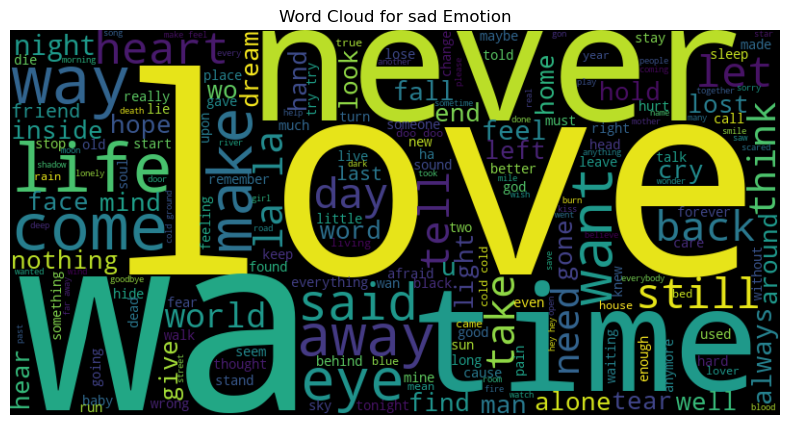

Table for happy Emotion:
          Word  TF-IDF Score
3289      love      0.309695
328       baby      0.218082
3159       let      0.217774
1118      come      0.209754
5514      take      0.205744
...        ...           ...
2952     juega      0.000308
2954   juicing      0.000308
2956  juliette      0.000308
2960  jumpsuit      0.000308
6363      zwei      0.000308

[6364 rows x 2 columns]


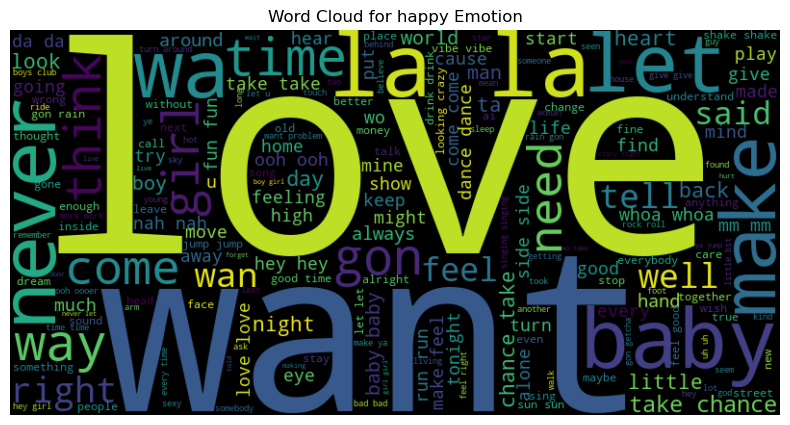

Table for angry Emotion:
            Word  TF-IDF Score
6770        time      0.221156
4386       never      0.178829
2808         gon      0.165073
3773        life      0.156608
7174          wa      0.151317
...          ...           ...
2214  eventually      0.000529
4855     plugged      0.000529
4856      plunge      0.000529
4857     plunged      0.000529
7507        zwei      0.000529

[7508 rows x 2 columns]


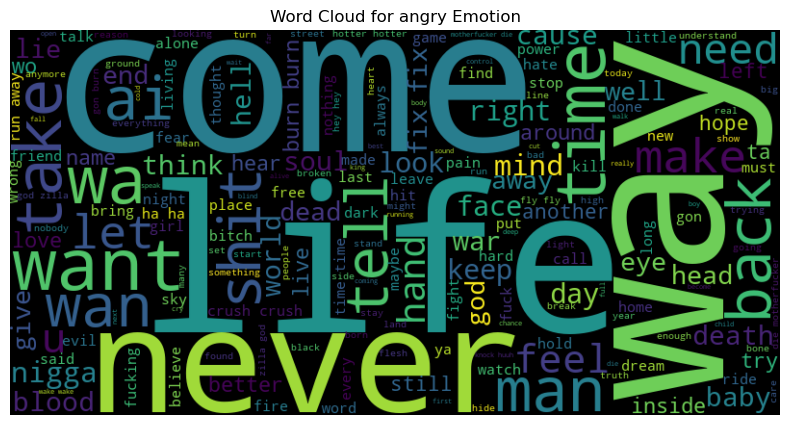

Table for relaxed Emotion:
              Word  TF-IDF Score
2446          love      0.365830
4255          time      0.198627
1014           day      0.181433
232           baby      0.173132
4582           way      0.170760
...            ...           ...
2129    ironically      0.000593
2130  irresistibly      0.000593
2131      irrigate      0.000593
2132        irvine      0.000593
4785          zone      0.000593

[4786 rows x 2 columns]


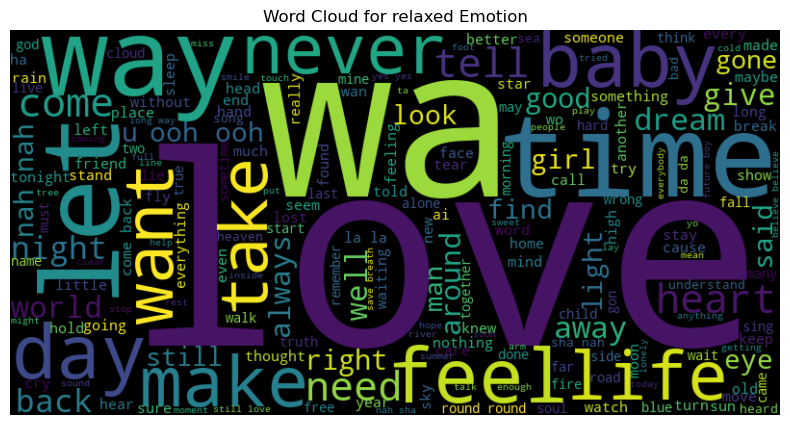

In [6]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

try:
    nltk.data.find('tokenizers/punkt')
    
except LookupError:
    nltk.download('popular')

stop_words = set(stopwords.words('english'))
additional_stop_words = ['like', 'get', 'got', 'know', 'yeah', 'just', 'one', 'see', 'say', 'thing', 'na', 'ca', 'go', 'oh']
stop_words.update(additional_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words = nltk.word_tokenize(text)
    return [lemmatizer.lemmatize(w).lower() for w in words if lemmatizer.lemmatize(w).lower() not in stop_words and w.isalpha()]

emotions = df['emotion'].unique()

for emotion in emotions:
    emotion_lyrics = ' '.join(df[df['emotion'] == emotion]['lyrics'])
    processed_lyrics = preprocess(emotion_lyrics)
    processed_text = " ".join(processed_lyrics)

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([processed_text])

    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]

    importance_df = pd.DataFrame({'Word': feature_names, 'TF-IDF Score': tfidf_scores})

    importance_df = importance_df.sort_values(by='TF-IDF Score', ascending=False)

    print(f'Table for {emotion} Emotion:')
    print(importance_df)

    wordcloud = WordCloud(background_color="black", width=800, height=400, margin=1).generate(processed_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {emotion} Emotion')
    plt.axis("off")
    plt.show()

    wordcloud.to_file(f'{emotion}_wordcloud.png')

In [7]:
# SVM Method

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_vectorized, y_train)

y_pred_svm = svm_classifier.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred_svm))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))

Accuracy: 0.51

Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.60      0.59        81
       happy       0.59      0.66      0.62       102
     relaxed       0.42      0.31      0.36        88
         sad       0.41      0.46      0.44        82

    accuracy                           0.51       353
   macro avg       0.50      0.51      0.50       353
weighted avg       0.51      0.51      0.51       353


Confusion Matrix:
[[49 10  5 17]
 [ 9 67 16 10]
 [12 22 27 27]
 [14 14 16 38]]


In [8]:
# Naive Bayes

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_vectorized, y_train)

y_pred_nb = naive_bayes_classifier.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred_nb)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred_nb))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_nb))

Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

       angry       0.80      0.40      0.53        81
       happy       0.58      0.77      0.66       102
     relaxed       0.47      0.08      0.14        88
         sad       0.36      0.71      0.48        82

    accuracy                           0.50       353
   macro avg       0.55      0.49      0.45       353
weighted avg       0.55      0.50      0.46       353


Confusion Matrix:
[[32 17  1 31]
 [ 3 79  3 17]
 [ 3 23  7 55]
 [ 2 18  4 58]]


In [9]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logistic_regression_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
logistic_regression_model.fit(X_train_vectorized, y_train)

y_pred_lr = logistic_regression_model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred_lr))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_lr))


Accuracy: 0.49

Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.57      0.55        81
       happy       0.58      0.66      0.61       102
     relaxed       0.41      0.26      0.32        88
         sad       0.39      0.45      0.42        82

    accuracy                           0.49       353
   macro avg       0.48      0.48      0.48       353
weighted avg       0.48      0.49      0.48       353


Confusion Matrix:
[[46 14  4 17]
 [11 67 14 10]
 [13 22 23 30]
 [17 13 15 37]]


In [13]:
# CNN
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=200))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

model.fit(X_train_pad, y_train_encoded, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))


Epoch 1/20
20/20 [==============================] - 3s 91ms/step - loss: 1.3878 - accuracy: 0.2606 - val_loss: 1.3899 - val_accuracy: 0.2113 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 2s 76ms/step - loss: 1.3603 - accuracy: 0.3472 - val_loss: 1.3750 - val_accuracy: 0.3028 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 2s 76ms/step - loss: 1.3191 - accuracy: 0.3740 - val_loss: 1.3535 - val_accuracy: 0.3310 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 2s 78ms/step - loss: 1.2573 - accuracy: 0.4094 - val_loss: 1.3281 - val_accuracy: 0.4437 - lr: 0.0010
Epoch 5/20
20/20 [==============================] - 2s 76ms/step - loss: 1.1392 - accuracy: 0.5409 - val_loss: 1.2903 - val_accuracy: 0.4155 - lr: 0.0010
Epoch 6/20
20/20 [==============================] - 2s 81ms/step - loss: 0.9058 - accuracy: 0.7110 - val_loss: 1.2602 - val_accuracy: 0.4718 - lr: 0.0010
Epoch 7/20
20/20 [==============================] - 2s 84ms/step - loss: 0.6

In [14]:
import pandas as pd
from sklearn.metrics import classification_report, precision_recall_fscore_support

precision_svm, recall_svm, f1_score_svm, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')
precision_nb, recall_nb, f1_score_nb, _ = precision_recall_fscore_support(y_test, y_pred_nb, average='weighted')
precision_lr, recall_lr, f1_score_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')
precision_cnn, recall_cnn, f1_score_cnn, _ = precision_recall_fscore_support(y_test_encoded, y_pred_classes, average='weighted')

metrics_df = pd.DataFrame({
    'Method': ['SVM', 'Naive Bayes', 'Logistic Regression', 'CNN'],
    'Precision': [precision_svm, precision_nb, precision_lr, precision_cnn],
    'Recall': [recall_svm, recall_nb, recall_lr, recall_cnn],
    'F1-Score': [f1_score_svm, f1_score_nb, f1_score_lr, f1_score_cnn]
})

print(metrics_df)


                Method  Precision    Recall  F1-Score
0                  SVM   0.506296  0.512748  0.506403
1          Naive Bayes   0.550211  0.498584  0.457165
2  Logistic Regression   0.482042  0.490085  0.480574
3                  CNN   0.427870  0.410765  0.415885
